In [40]:
%matplotlib widget
import spb
import sympy as sp
from sympy import sin, cos, pi, sqrt, acos, simplify, atan
sp.init_printing()

In [41]:
# Helper functions
from typing import List


def homogeneous(rotation: sp.Matrix = sp.eye(3), translation: sp.Matrix = sp.zeros(3, 1)) -> sp.Matrix:
    return rotation.row_join(translation).col_join(sp.Matrix([[0, 0, 0, 1]]))

def dh(rotation, twist, displacement, offset):
    rotation_mat = sp.Matrix([
        [cos(rotation), -sin(rotation)*cos(twist),  sin(rotation)*sin(twist)],
        [sin(rotation), cos(rotation)*cos(twist),   -cos(rotation)*sin(twist)],
        [0,             sin(twist),                 cos(twist)],
    ])
    translation = sp.Matrix([
        [offset*cos(rotation)],
        [offset*sin(rotation)],
        [displacement],
    ])
    return rotation_mat, translation

def rotation(homogeneous: sp.Matrix):
    return homogeneous[:3, :3]

def translation(homogeneous: sp.Matrix):
    return homogeneous[:3, 3:]

def jacobian(transforms: List[sp.Matrix], joint_types: List[sp.Matrix], base_z: sp.Matrix = sp.Matrix([0, 0, 1])):
    transforms_chained = [homogeneous()]
    z_unit_vecs = []
    # chain the transforms
    for i, transform in enumerate(transforms):
        transforms_chained.append(transforms_chained[-1] * transform)
    # apply rotation of chained transforms to base z
    for chained_transform in transforms_chained:
        z_unit_vecs.append(rotation(chained_transform) * base_z)
    
    assert len(transforms_chained) == len(z_unit_vecs)

    jacobian = sp.zeros(6, len(transforms))
    for i, (transform, joint_type) in enumerate(zip(transforms, joint_types)):
        if joint_type == 'revolute':
            jacobian[:3, i] = z_unit_vecs[i].cross(translation(transforms_chained[-1]) - translation(transforms_chained[i]))
            jacobian[3:, i] = z_unit_vecs[i]
        elif joint_type == 'prismatic':
            jacobian[:3, i] = z_unit_vecs[i]
            jacobian[3:, i] = sp.Matrix([[0], [0], [0]])

        # angular velocity

    return jacobian

In [42]:
theta_1, theta_2, theta_3 = sp.symbols('theta_1 theta_2 theta_3')
a_1 = 0.01 * (50*sqrt(2)-50)
a_2 = 0.01 * (25*sqrt(2))
a_3 = 0.01 * 10

tf_1 = homogeneous(*dh(theta_1, 0, 0, a_1))
tf_2 = homogeneous(*dh(theta_2, 0, 0, a_2))
tf_3 = homogeneous(*dh(theta_3, 0, 0, a_3))
tf = tf_1 * tf_2 * tf_3

jac = jacobian([tf_1, tf_2, tf_3], ['revolute', 'revolute', 'revolute'])

display(simplify(tf))
simplify(jac)

⎡cos(θ₁ + θ₂ + θ₃)  -sin(θ₁ + θ₂ + θ₃)  0  -0.5⋅cos(θ₁) + 0.5⋅√2⋅cos(θ₁) + 0.2
⎢                                                                             
⎢sin(θ₁ + θ₂ + θ₃)  cos(θ₁ + θ₂ + θ₃)   0  -0.5⋅sin(θ₁) + 0.5⋅√2⋅sin(θ₁) + 0.2
⎢                                                                             
⎢        0                  0           1                                     
⎢                                                                             
⎣        0                  0           0                                     

5⋅√2⋅cos(θ₁ + θ₂) + 0.1⋅cos(θ₁ + θ₂ + θ₃)⎤
                                         ⎥
5⋅√2⋅sin(θ₁ + θ₂) + 0.1⋅sin(θ₁ + θ₂ + θ₃)⎥
                                         ⎥
  0                                      ⎥
                                         ⎥
  1                                      ⎦

⎡-0.5⋅√2⋅sin(θ₁) + 0.5⋅sin(θ₁) - 0.25⋅√2⋅sin(θ₁ + θ₂) - 0.1⋅sin(θ₁ + θ₂ + θ₃) 
⎢                                                                             
⎢-0.5⋅cos(θ₁) + 0.5⋅√2⋅cos(θ₁) + 0.25⋅√2⋅cos(θ₁ + θ₂) + 0.1⋅cos(θ₁ + θ₂ + θ₃) 
⎢                                                                             
⎢                                     0                                       
⎢                                                                             
⎢                                     0                                       
⎢                                                                             
⎢                                     0                                       
⎢                                                                             
⎣                                     1                                       

 -0.25⋅√2⋅sin(θ₁ + θ₂) - 0.1⋅sin(θ₁ + θ₂ + θ₃)  -0.1⋅sin(θ₁ + θ₂ + θ₃)⎤
                                                          

In [43]:
from math import degrees, radians


sol=jac.evalf(subs={theta_1: radians(120), theta_2: radians(-120), theta_3: radians(-90)})*sp.Matrix([[radians(5)], [radians(120)], [radians(20)]])
display(degrees(sol[0]))
display(degrees(sol[1]))
display(degrees(sol[5]))

In [44]:
jac = jac[[0, 1, 5], :]
jac.inv().evalf(subs={theta_1: .53, theta_2: 1.122, theta_3: -1.652})*sp.Matrix([[0], [0.1], [0]])

⎡0.534148353946553⎤
⎢                 ⎥
⎢-0.69285110817237⎥
⎢                 ⎥
⎣0.158702754225817⎦

⎡-0.25⋅√2⋅sin(θ₁)⋅cos(θ₂) - (-0.5 + 0.5⋅√2)⋅sin(θ₁) - 0.25⋅√2⋅sin(θ₂)⋅cos(θ₁) 
⎢                                                                             
⎣-0.25⋅√2⋅sin(θ₁)⋅sin(θ₂) + 0.25⋅√2⋅cos(θ₁)⋅cos(θ₂) + (-0.5 + 0.5⋅√2)⋅cos(θ₁) 

 -0.25⋅√2⋅sin(θ₁)⋅cos(θ₂) - 0.25⋅√2⋅sin(θ₂)⋅cos(θ₁)⎤
                                                   ⎥
 -0.25⋅√2⋅sin(θ₁)⋅sin(θ₂) + 0.25⋅√2⋅cos(θ₁)⋅cos(θ₂)⎦

0.0659688865125542
0.0679981441964928
0.0696300761267107
0.0709119882824339
0.0718817552597168
0.0725704058511112
0.0730038530735647
0.0732040931009509
0.0731900610590406
0.0729782575149106
0.0725832172481421
0.0720178668075698
0.0712938019282378
0.0704215060969180
0.0694105251784600
0.0682696087620268
0.0670068259902394
0.0656296616273223
0.0641450967115494
0.0625596771356185
0.0608795727849752
0.0591106293598676
0.0572584146616213
0.0553282609070204
0.0533253045322635
0.0512545249597007
0.0491207839422228
0.0469288674082253
0.0446835322714818
0.0423895615607896
0.0400518326616157
0.0376754057865446
0.0352656435991045
0.0328283792731932
0.0303701611336884
0.0278986210703221
0.0254230482278742
0.0229553129477218
0.0205114060024874
0.0181140875244434
0.0157975678237825
0.0136158458367239
0.0116569283150623
0.0100625913000164
0.00903636766257833
0.00878458327296536
0.00937090800904469
0.0106557597801776
0.0124198223467894
0.0144830371115766


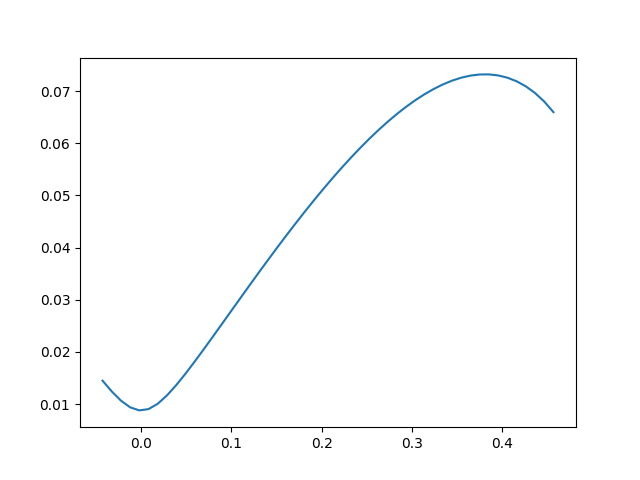

In [46]:
import math
import numpy as np


def solve_ik_simple(px, py, L1, L2):
    F = (px**2 + py**2 - L1**2 - L2**2)/(2* L1)
    q2 = 2*atan( sqrt( L2**2 - F**2 )/(L2 + F) )
    M = L1 + L2*cos( q2 )
    n = L2*sin( q2 )
    cosq1 = (px*M + py*n)/(M**2 + n**2)
    sinq1 = (py - n*cosq1)/M
    q1 = atan( sinq1/cosq1 )
    return q1, q2

dets = []
ys = np.linspace((50*math.sqrt(2)-25)*.01, (50*math.sqrt(2)-75)*.01, 50)
jac = jacobian([tf_1, tf_2], ['revolute', 'revolute'])[[0, 1], :]
display(jac)
for y in ys:
    q1, q2 = solve_ik_simple(15*.01, y, a_1, a_2)
    det = jac.evalf(subs={theta_1: q1, theta_2: q2}).det()
    print(det)
    dets.append(det)

import matplotlib.pyplot as plt
plt.plot(ys, dets)
plt.show()
